In [1]:
import numpy as np
import os
import sys       

%load_ext autoreload
%autoreload 2

# Get the path of the parent_directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Append the parent_directory to sys.path
sys.path.append(parent_dir)
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

from patch.Processing.processECG import process_ECG
from patch.Processing.processPPG import process_PPG, select_ppg_array, extract_PPG_fiducial
from patch.Processing.processSCG import process_SCG, extract_SCG_fiducials
from patch.Tools.preprocessing import get_filt_dict, dict_interpolation
from patch.Tools.pipelineConfig import *
from patch.Tools.patchParser import get_newest_patch_file, parse_file

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Parse raw binary patch file and plot raw signals

In [4]:
# Parse through binary file and get raw signals formatted into dict (otherwise read the .csv files)
use_patch = True 
# change to path contianign cardiopulse.bin file 
datapath = '/home/dlin/Dropbox (GaTech)/Darpa/PatchUtil/data/'
datapath = '/home/michael/Code/mims-transformer-stress-classification/data/raw/bin_files/'
if use_patch:
    patch_fname = '3129'
    raw_dict = parse_file(datapath+patch_fname+'.bin')
    outputdir = datapath
    
else:

    ecg_data = pd.read_csv(datapath + 'ECG-processed.csv')
    ppg_data = pd.read_csv(datapath + 'PPG-processed.csv')
    scg_data = pd.read_csv(datapath + 'SCG-processed.csv')
    # replace all dictionary values with csv values
    raw_dict = {}
    raw_dict['ecg_time'] = ecg_data['Timestamp'].to_numpy()/1e9
    raw_dict['ecg'] = ecg_data['Value'].to_numpy()
    raw_dict['accel_time'] = scg_data['Timestamp'].to_numpy()/1e9
    raw_dict['accel_x'] = scg_data['AccelerationX'].to_numpy()
    raw_dict['accel_y'] = scg_data['AccelerationY'].to_numpy()
    raw_dict['accel_z'] = scg_data['AccelerationZ'].to_numpy()
    raw_dict['ppg_time'] = ppg_data['Timestamp'].to_numpy()/1e9
    raw_dict['ppg_ir_1'] = ppg_data['Infrared1'].to_numpy()*-1
    raw_dict['ppg_ir_2'] = ppg_data['Infrared2'].to_numpy()*-1
    raw_dict['ppg_r_1'] = ppg_data['Red1'].to_numpy()*-1
    raw_dict['ppg_r_2'] = ppg_data['Red2'].to_numpy()*-1
    raw_dict['ppg_g_1'] = ppg_data['Green1'].to_numpy()*-1
    raw_dict['ppg_g_2'] = ppg_data['Green2'].to_numpy()*-1

    # # get non-zero trigger timings
    # trigger_pd = ecg_data[ecg_data['Trigger'] != 0][['Timestamp', 'Trigger']]
    # trigger_pd = trigger_pd.rename(columns = {'Timestamp': 'time'})

Device name: HP-0022
Last sync time: Mon Mar 28 14:42:45 2022 UTC
Accel Size: 20724537
PPG Size: 1363385
ECG Size: 10312937
Environmental Size: 41449
AST Time Length: 20642.462646484375
204635360 100.0% done                      

STATS:
Measurement Length: 20642.38 seconds
File Size: 204635.648 kbytes
Average data rate: 9913.37 bytes/second
Theoretical uncompressed data rate: 17242.98 bytes/second
PPG is 11.99% of the data
ECG is 13.86% of the data
Accel is 49.72% of the data
Environmental is 0.14% of the data
AST is 10.16% of the data
Data Flag is 10.13% of the data
time ellapsed: 40.361 seconds
parse speed: 5070134.917 bytes/second
parse speed: 511.444 dataSeconds/second


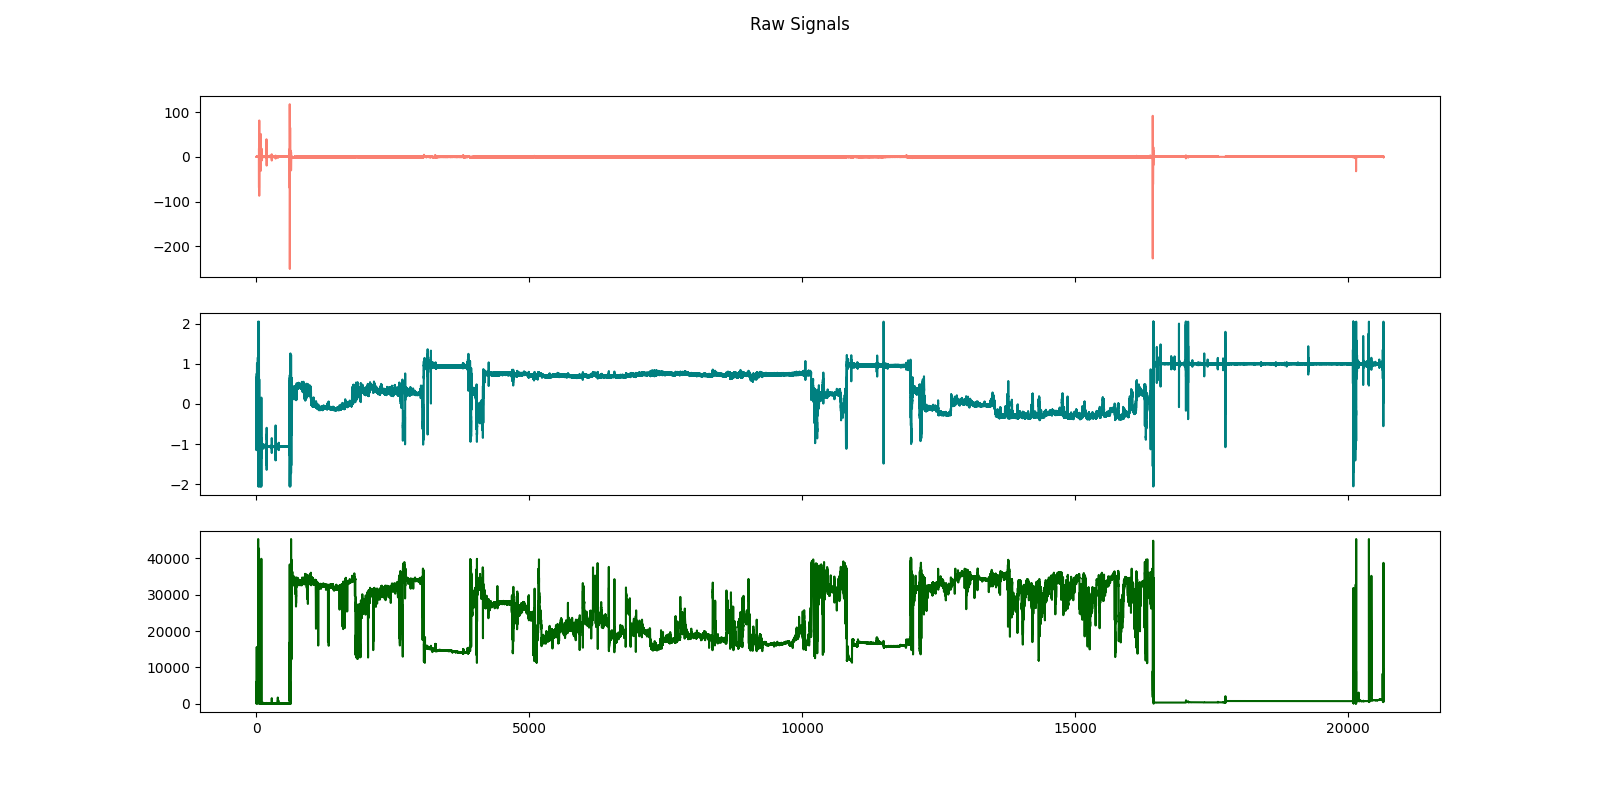

In [5]:
#%matplotlib inline
fig, axs = plt.subplots(3,1, sharex=True, figsize=(16,8))
plt.suptitle("Raw Signals")
axs[0].plot(raw_dict['ecg_time'], raw_dict['ecg'], color='salmon')
axs[1].plot(raw_dict['accel_time'], raw_dict['accel_z'], color='teal')
axs[2].plot(raw_dict['ppg_time'], raw_dict['ppg_ir_2'], color='darkgreen')
plt.show()

#### Resample to uniformity

In [6]:
patch_dict = dict_interpolation(raw_dict, fs_resample=FS_RESAMPLE)
print(patch_dict.keys())

dict_keys(['ecg', 'scg_LT', 'scg_HF', 'scg_DV', 'ppg_g_1', 'ppg_r_1', 'ppg_ir_1', 'ppg_g_2', 'ppg_r_2', 'ppg_ir_2', 'temp_skin', 'time'])


#### Filter signals and plot

In [7]:
patch_filt_dict = get_filt_dict(patch_dict, FILT_ECG, FILT_SCG, FILT_PPG, Fs=FS_RESAMPLE)

(-100.0, 100.0)

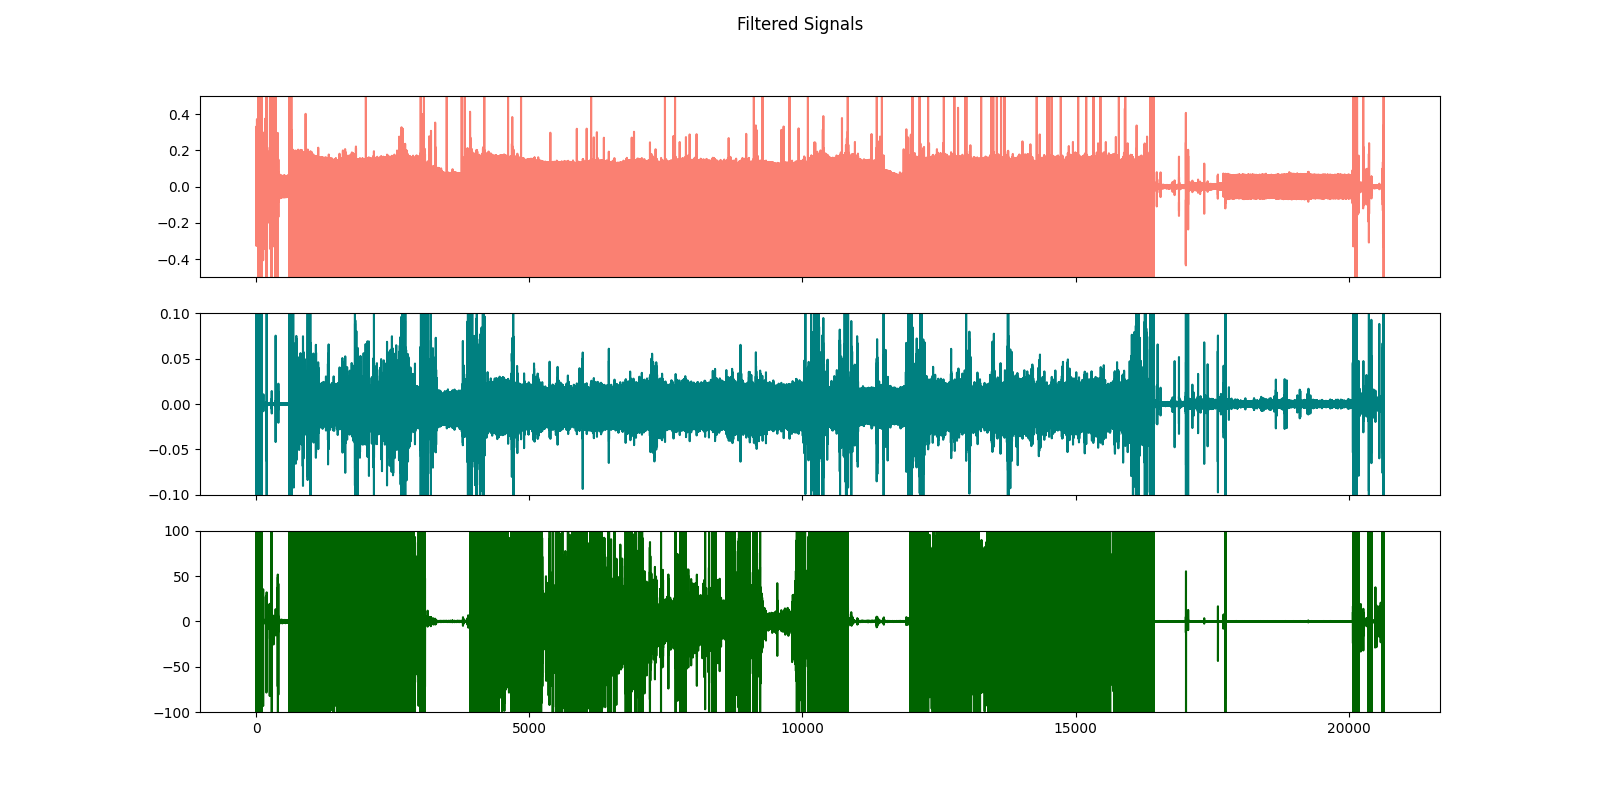

In [8]:
%matplotlib widget
fig, axs = plt.subplots(3,1, sharex=True, figsize=(16,8))
plt.suptitle("Filtered Signals")
axs[0].plot(patch_filt_dict['time'], patch_filt_dict['ecg'], color='salmon'); axs[0].set_ylim([-0.5, 0.5])
axs[1].plot(patch_filt_dict['time'], patch_filt_dict['scg_DV'], color='teal'); axs[1].set_ylim([-0.1, 0.1])
axs[2].plot(patch_filt_dict['time'], patch_filt_dict['ppg_g_2'], color='darkgreen'); axs[2].set_ylim([-100, 100])


#### Get R-peaks from the ECG

ECG signal was inverted.
Number of peaks found:
   Neurokit (16922)
   Martinez (118)
   Kalidas (59)
   Common (59)
31 NN intervals detected from 59 peaks.


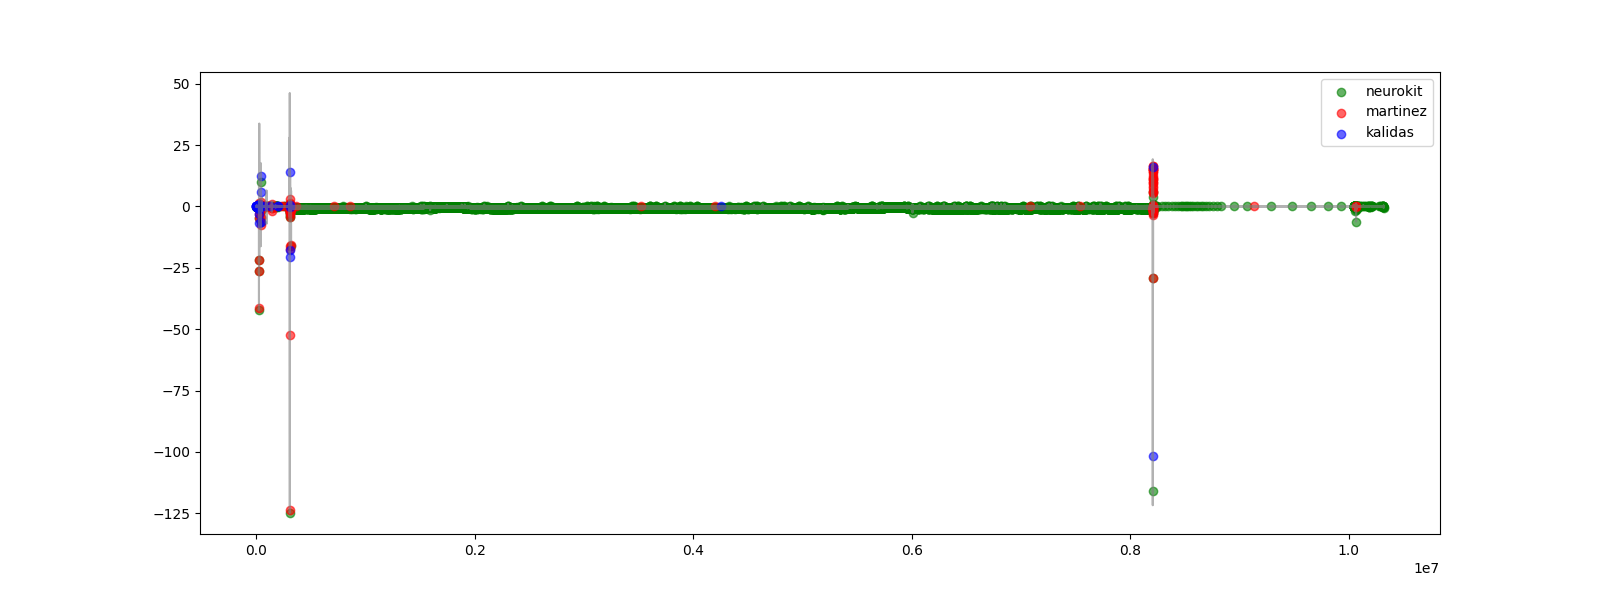

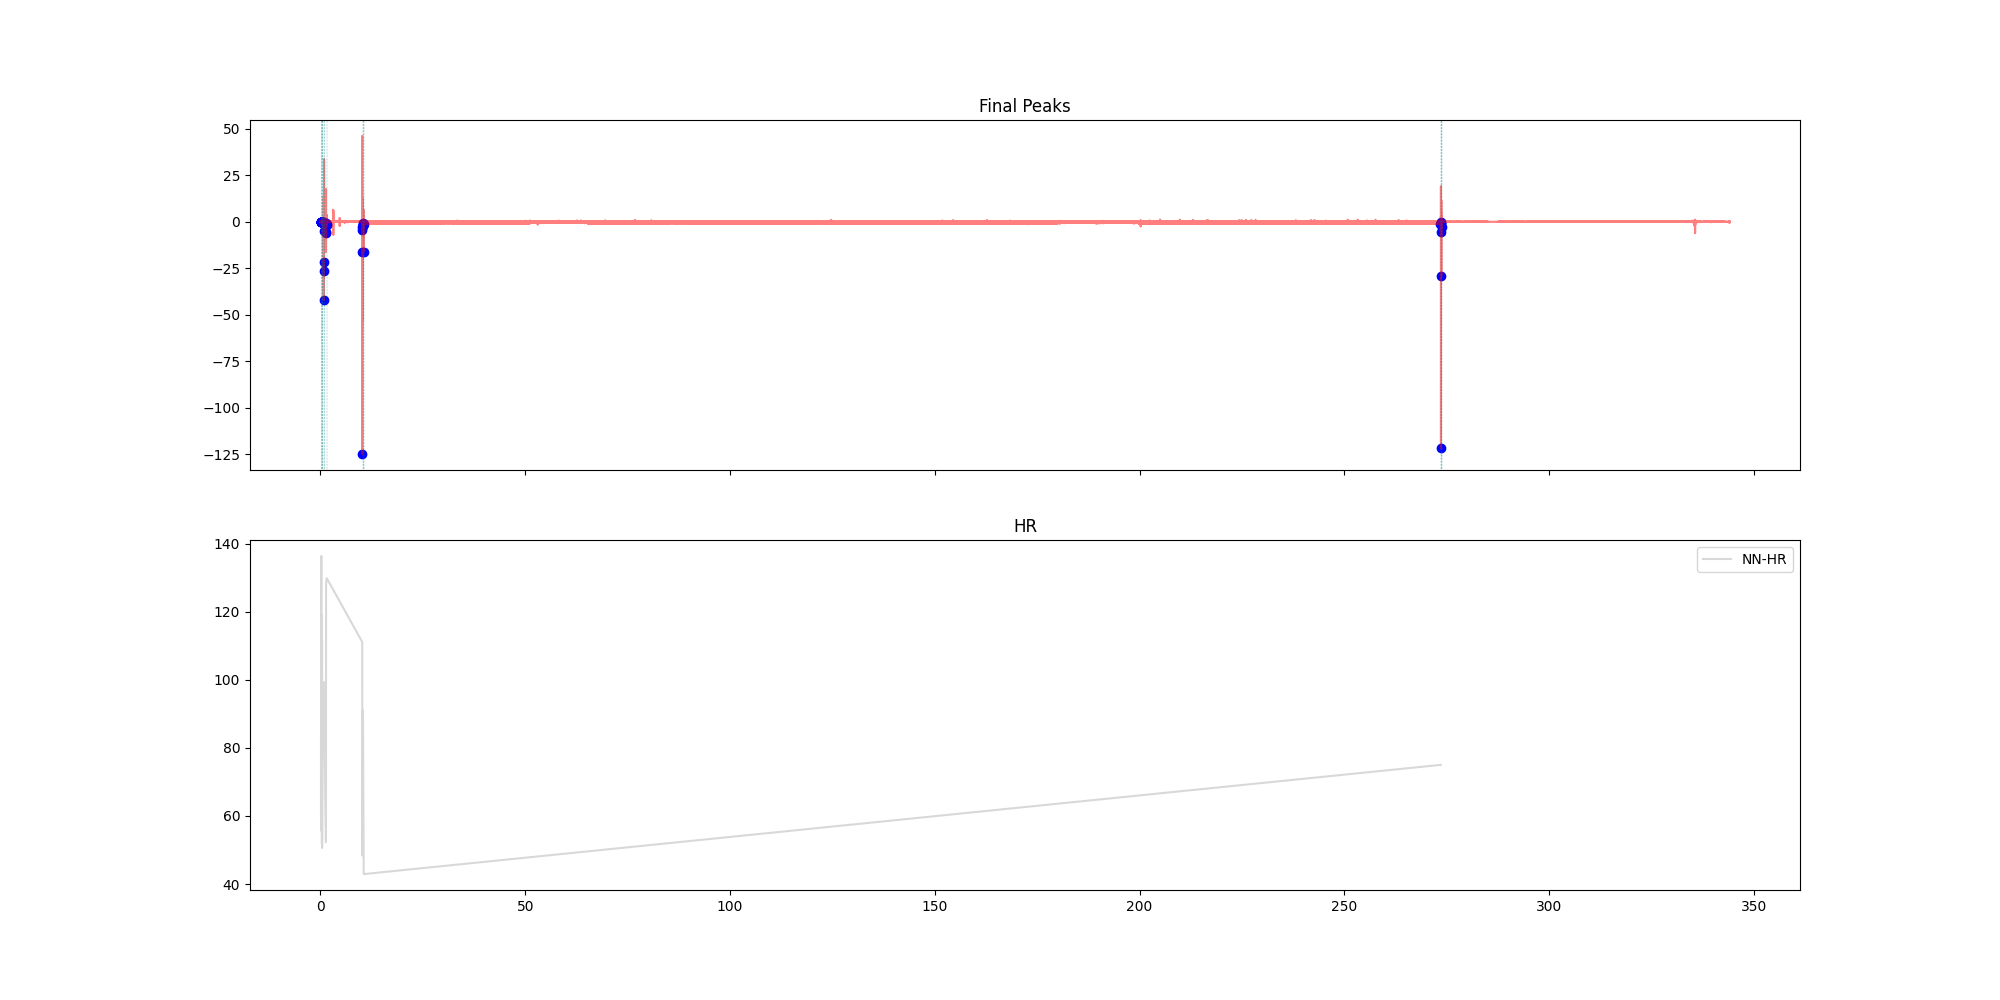

In [9]:
# Note we pass the raw ECG here, as we use different R-peak detectors that each require specific filtering
ecg_dict = process_ECG(patch_dict['ecg'],
                        patch_dict['time'],
                        force_inverse=False,
                        width_QRS=width_QRS,
                        peak_tol=pk_tolerance_ms, 
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True, 
                        plotFlag=True)

#### Get quality PPG and SCG beats

Using PPG array 2
Begin processing PPG
Stage 1: Global MAD removed 94 out of 1864
Stage 2: Moving window MAD removed 40 out of 1770
Stage 3: Moving window DTW removed 210 out of 1730
Stage 4: Global DTW fusion removed 233 out of 1730
Final: Using 1672 beats out of 1864


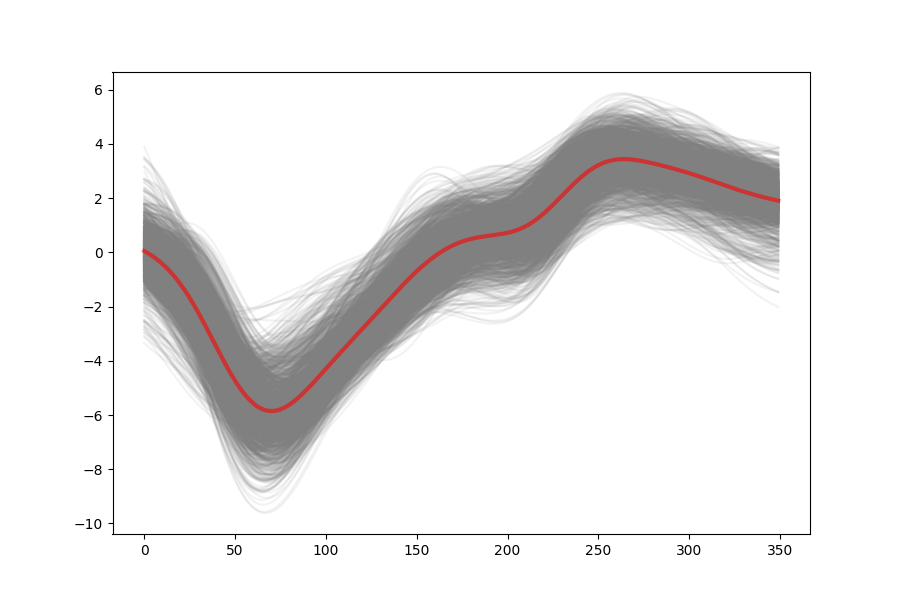

In [ ]:
# PPG Array selection
ppg_arr,_ = select_ppg_array(patch_filt_dict[ppg_wavelen+'_1'], 
                            patch_filt_dict[ppg_wavelen+'_2'], 
                            verbose=True)

# Process PPG
ppg_dict = process_PPG(patch_filt_dict[ppg_wavelen+ppg_arr], 
                        patch_dict[ppg_wavelen+ppg_arr], 
                        ecg_dict, 
                        ensembleSize=ensemble_length, 
                        useTemplateSQI=True,
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True)

plt.figure(figsize=(9, 6))
_=plt.plot(ppg_dict['ppg_beats'], color='gray', alpha=0.1)
_=plt.plot(np.mean(ppg_dict['ppg_beats'], axis=1), color='red', alpha=0.6, lw=3)

Begin processing SCG...
Stage 1: Global MAD removed 135 out of 1864
Stage 2: Moving window MAD removed 13 out of 1729
Stage 3: Moving window DTFM removed 31 out of 1716
Stage 4: Global DTFM removed 24 out of 1716
Final: Using 1685 beats out of 1864


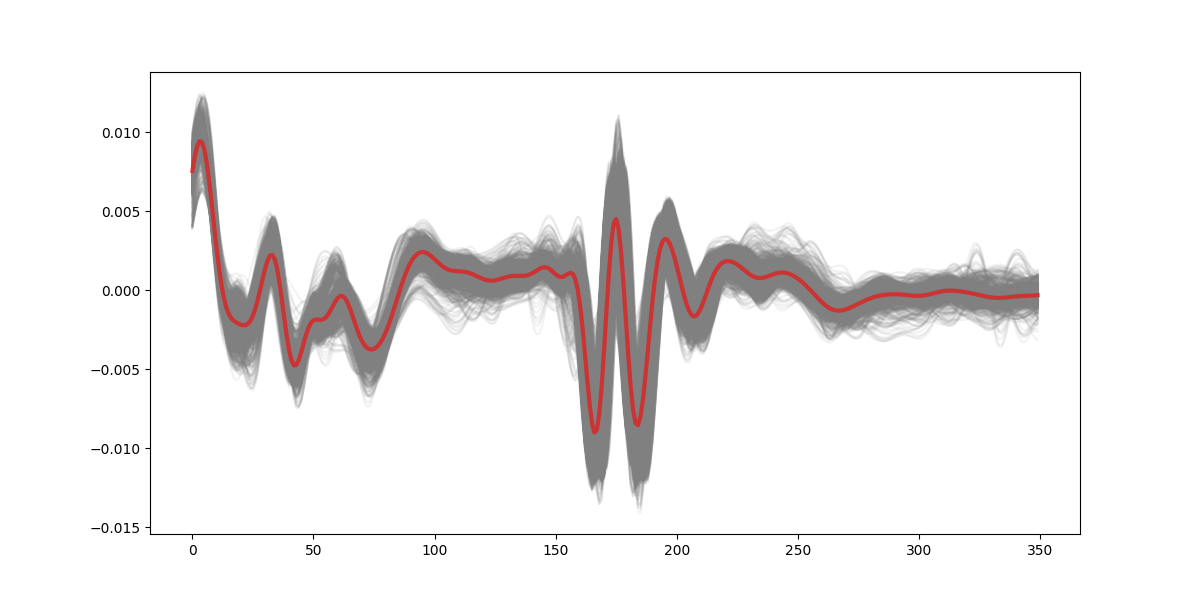

In [ ]:
# Process SCG
scg_dict = process_SCG(patch_filt_dict['scg_DV'], 
                        patch_filt_dict['pcg_DV'], 
                        ecg_dict, 
                        ensembleSize=ensemble_length, 
                        useTemplateSQI=True,
                        beat_len=beat_length, 
                        Fs=FS_RESAMPLE, 
                        verbose=True)

plt.figure(figsize=(12, 6))
_=plt.plot(scg_dict['scg_beats'], color='gray', alpha=0.1)
_=plt.plot(np.mean(scg_dict['scg_beats'], axis=1), color='red', alpha=0.6, lw=3)

#### Save processed beat dicts as intermediate output

In [ ]:
# with open(outputdir+out_fname+'_preprocessed.pickle','wb') as f:
#     pickle.dump([patch_dict, ecg_dict, ppg_dict, scg_dict], f)

#### Get SCG fiducial points and inspect candidates

In [ ]:
scg_fid_dict = extract_SCG_fiducials(scg_dict, 
                                    num_features_ao=4, 
                                    num_features_ac=3, 
                                    ema_factor=1.0, 
                                    verbose=True, 
                                    method = 'GMM') # choose between 'GMM', 'Template', or 'Jon'

ao_locs, ac_locs, flagged_ao, flagged_ac = np.squeeze(scg_fid_dict['ao_locs']), np.squeeze(scg_fid_dict['ac_locs']), scg_fid_dict['flagged_ao'], scg_fid_dict['flagged_ac']
scg_beats_used = scg_fid_dict['beats_used']
# Update these as they may have been reduced to find possible candidates
num_feats_ao, num_feats_ac = np.shape(scg_fid_dict['ao_cands'])[0], np.shape(scg_fid_dict['ac_cands'])[0]

# Plot results of fiducial tracking
scg_beats = scg_dict['scg_beats'].copy()

print(f"Least deviation ao_loc={np.argmin(np.nanstd(scg_fid_dict['ao_cands'], axis=1))}")
if num_feats_ac > 1:
    max_idx = np.nanmax(scg_fid_dict['ac_cands'][-1].T)
    print(f"Least deviation ac_loc={np.argmin(np.nanstd(scg_fid_dict['ac_cands'], axis=1))}")
else:
    max_idx = np.nanmax(scg_fid_dict['ac_cands'])
    print(f"Least deviation ac_loc={np.argmin(np.nanstd(scg_fid_dict['ac_cands']))}")
scg_beats = np.ceil(255 * (scg_beats / scg_beats.max(axis=0)))

f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(scg_beats[:int(max_idx),:], cmap='gray',vmin = 0, vmax = 255, aspect='auto')
ax[0].plot(scg_fid_dict['ao_cands'].T, color='red', alpha=0.3)
ax[0].plot(scg_fid_dict['ac_cands'].T, color='red', alpha=0.3)
ax[0].plot(ao_locs.T, color='blue', alpha=0.8, label = 'AO')
ax[0].plot(ac_locs.T, color='g', alpha=0.8, label = 'AC')
ax[0].plot(scg_fid_dict['s1_loc']*np.ones(len(scg_fid_dict['ao_locs'])), color='green', lw=3, alpha=0.2)
ax[0].set_ylabel('Time from R-peak [samples]')
ax[0].set_xlabel('Beats')
ax[0].legend()

ao_amp = [scg_dict['scg_beats'][ao_loc_i, scg_beat_idx][0] for ao_loc_i, scg_beat_idx in zip(scg_fid_dict['ao_locs'].astype(int), scg_fid_dict['flagged_ao'])]
ac_amp = [scg_dict['scg_beats'][ac_loc_i, scg_beat_idx][0] for ac_loc_i, scg_beat_idx in zip(scg_fid_dict['ac_locs'].astype(int), scg_fid_dict['flagged_ac'])]
ax[1].plot(scg_dict['scg_beats'], color='gray', alpha=0.1)
ax[1].plot(np.mean(scg_dict['scg_beats'], axis=1), color='red', alpha=0.6, lw=3)
ax[1].scatter(scg_fid_dict['ao_locs'], ao_amp, alpha = 0.3, color = 'tab:blue', label = 'AO')
ax[1].scatter(scg_fid_dict['ac_locs'], ac_amp, alpha = 0.3, color = 'tab:green', label = 'AC')
ax[1].set_xlabel('Time from R-peak [samples]')
ax[1].set_ylabel('SCG amplitude')
ax[1].legend()


Engine started...


Unrecognized function or variable 'general.slideTemplate'.



MatlabExecutionError: Undefined function 'general.slideTemplate' for input arguments of type 'int64'.


#### Get PPG fiducial point and inspect

In [ ]:
ppg_fid_dict = extract_PPG_fiducial(ppg_dict, memory=30, smooth=10, max_dist_foot=max_dist_foot)

ppg_beats = ppg_dict['ppg_beats'].copy()
ppg_beats = np.ceil(255 * (ppg_beats / ppg_beats.max(axis=0)))

f, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].imshow(ppg_beats, cmap='gray',vmin = 0, vmax = 255, aspect='auto')
ax[0].plot(ppg_fid_dict['pulse_locs'], color='blue', alpha=0.6, label = 'PAT')
ax[0].set_ylabel('Time from R-peak [samples]')
ax[0].set_xlabel('Beats')
ax[0].legend()


ppg_pat_amp = [ppg_dict['ppg_beats'][pat_loc_i, i] for i, pat_loc_i in  enumerate(ppg_fid_dict['pulse_locs'].astype(int))]
ax[1].plot(ppg_dict['ppg_beats'], color='gray', alpha=0.1)
ax[1].plot(np.mean(ppg_dict['ppg_beats'], axis=1), color='red', alpha=0.6, lw=3)
ax[1].scatter(ppg_fid_dict['pulse_locs'], ppg_pat_amp, alpha = 0.3, color = 'tab:blue', label = 'PAT')
ax[1].set_xlabel('Time from R-peak [samples]')
ax[1].set_ylabel('PPG amplitude')
ax[1].legend()

#### Feature extraction - probably want to make these into functions for each signal

In [ ]:
feat_df = pd.DataFrame()

##### Get timestamps to reference all features to

In [ ]:
t_feats = ecg_dict['t_beats']
feat_df['time'] = t_feats

##### ECG features

Recall, HR is already found

In [ ]:
feat_df['hr'] = ecg_dict['hr']

HRV Analysis

In [ ]:
# Prerequisite check to see if greater than 5 minutes of data is present (necessary to compute all HRV features)
if (feat_df['time'].values[-1] - feat_df['time'].values[0]) < 5*60:
    print('Not enough data for HRV analysis')
    # Frequency-domain
    feat_df['hrv_lf'], feat_df['hrv_hf'], feat_df['hrv_lf'] = np.nan, np.nan, np.nan
    # Time-domain
    feat_df['hrv_rmssd'], feat_df['hrv_sd'], feat_df['hrv_sdsd'], feat_df['hrv_sdnn'] = np.nan, np.nan, np.nan, np.nan
# If there is enough data, compute HRV features
# else:
#   # Frequency-domain

#   # Time-domain


##### SCG features

PEP, LVET, and PEP/LVET

In [ ]:
feat_PEP = np.squeeze((scg_fid_dict['ao_locs'][scg_fid_dict['flagged_ao']])*1000/FS_RESAMPLE)
ao_times = np.intersect1d(scg_fid_dict['t_ao'], feat_df.time.values)
# Add PEP values to df
for i, ao_time in enumerate(ao_times):
    feat_df.loc[feat_df.time == ao_time, 'pep'] = feat_PEP[i]

# Get beats with defined AO and AC points
ac_times = np.intersect1d(scg_fid_dict['t_ac'], feat_df.time.values)
_, ao_ind, ac_ind = np.intersect1d(ao_times, ac_times, return_indices=True)
pep_lvet_times = ao_times[ao_ind]
feat_PEP_LVET = np.squeeze((ao_locs[ao_ind])*1000/FS_RESAMPLE) / np.squeeze((ac_locs[ac_ind])*1000/FS_RESAMPLE)
# Add PEP/LVET values to df
for i, pep_lvet_time in enumerate(pep_lvet_times):
    feat_df.loc[feat_df.time == pep_lvet_time, 'pep_lvet'] = feat_PEP_LVET[i]
    
feat_LVET = np.squeeze((ac_locs[ac_ind])*1000/FS_RESAMPLE) - np.squeeze((ao_locs[ao_ind])*1000/FS_RESAMPLE)
# Add LVET values to df
for i, ac_time in enumerate(pep_lvet_times):
    feat_df.loc[feat_df.time == ac_time, 'lvet'] = feat_LVET[i]

##### PPG features

Recall, PPG amplitude is already found

In [ ]:
ppg_amp_ac = ppg_dict['ppg_amp_ac']
ppg_amp_ac_dc = ppg_dict['ppg_amp'] # AC amplitude normalized by DC (in case of changes in contact pressure)
t_ppg_amp = ppg_dict['t_ppg_amp']
# Add PPG amplitude values to df
for i, ppg_amp_time in enumerate(t_ppg_amp):
    feat_df.loc[feat_df.time == ppg_amp_time, 'ppg_amp_ac'] = ppg_amp_ac[i]
    feat_df.loc[feat_df.time == ppg_amp_time, 'ppg_amp'] = ppg_amp_ac_dc[i]

PAT and PTT

In [ ]:
feat_PAT = ppg_fid_dict['pulse_locs']
t_pat = ppg_fid_dict['t_pulse']
# Add PAT values to df
for i, pat_time in enumerate(t_pat):
    feat_df.loc[feat_df.time == pat_time, 'pat'] = feat_PAT[i]

# Find overlapping beats with PAT and PEP values for PTT
_, pat_ind, pep_ind = np.intersect1d(t_pat, ao_times, return_indices=True)
pat_for_ptt = feat_PAT[pat_ind]
pep_for_ptt = feat_PEP[pep_ind]
feat_PTT = pat_for_ptt - pep_for_ptt
t_ptt = t_pat[pat_ind]
# Add PTT values to df
for i, ptt_time in enumerate(t_ptt):
    feat_df.loc[feat_df.time == ptt_time, 'ptt'] = feat_PTT[i]

In [ ]:
# Add trigger times into the feature dataframe 
feat_df = pd.concat([feat_df, trigger_pd], names= 'time')
feat_df = feat_df.sort_values(by = 'time', ignore_index= True)

#### Inspect feature dataframe

In [ ]:
feat_df

In [ ]:
f, ax = plt.subplots(3, 1, figsize = (16, 6), sharex = True)


# Plot trigger points
for trigger_time in feat_df[~np.isnan(feat_df['Trigger'])]['time'].values:
    ax[0].axvline(trigger_time, linestyle = '--', color = 'k')
    ax[1].axvline(trigger_time, linestyle = '--', color = 'k')
    ax[2].axvline(trigger_time, linestyle = '--', color = 'k', label = 'Trigger')

# Plot r-peak (ecg) features
r_peak_idx = [np.argmin(np.abs(patch_filt_dict['time'] - rpeak_i)) for rpeak_i in feat_df['time']]
ax[0].plot(patch_filt_dict['time'], patch_filt_dict['ecg'], color='salmon')
ax[0].scatter(feat_df['time'], patch_filt_dict['ecg'][r_peak_idx], color = 'tab:blue', label = 'R-peak')
ax[0].legend()
ax[0].set_ylabel('ecg')

# Plot ao (scg) features
ao_loc = feat_df['time'] + feat_df['pep']/1000
ao_idx = [np.argmin(np.abs(patch_filt_dict['time'] - ao_loc_i)) for ao_loc_i in ao_loc]
ax[1].plot(patch_filt_dict['time'], patch_filt_dict['scg_DV'], color='teal')
ax[1].scatter(feat_df['time'] + feat_df['pep']/1000, patch_filt_dict['scg_DV'][ao_idx], color = 'tab:orange', label = 'AO')


# Plot ac (scg) features
ac_loc = feat_df['time'] + (feat_df['lvet'] +  feat_df['pep'])/1000
ac_idx = [np.argmin(np.abs(patch_filt_dict['time'] - ac_loc_i)) for ac_loc_i in (ac_loc)]
ax[1].scatter(ac_loc, patch_filt_dict['scg_DV'][ac_idx], color = 'tab:purple', label = 'AC')
ax[1].set_ylim([-0.1, 0.1])
ax[1].legend()
ax[1].set_ylabel('scg')

# Plot pat (ppg) features
pat_loc = feat_df['time'] + feat_df['pat']/1000
pat_idx = [np.argmin(np.abs(patch_filt_dict['time'] - pat_loc_i)) for pat_loc_i in (pat_loc)]
ax[2].plot(patch_filt_dict['time'], patch_filt_dict[ppg_wavelen+ppg_arr], color='darkgreen')
ax[2].scatter(pat_loc, patch_filt_dict[ppg_wavelen+ppg_arr][pat_idx], color = 'k', label = 'ppg foot')
ax[2].set_ylim([-200, 200])
ax[2].legend()
ax[2].set_ylabel('ppg')
ax[2].set_xlabel('Time (s)')


##### Plot features

In [ ]:
feats_to_plot = ['hr', 'pep', 'lvet', 'pep_lvet', 'ppg_amp_ac', 'pat', 'ptt']
feat_units = ['bpm', 'ms', 'ms', 'a.u.', 'uW', 'ms', 'ms']
colors = sns.color_palette(palette='Set2', n_colors=len(feats_to_plot))
fig, axs = plt.subplots(len(feats_to_plot), 1, sharex=True, figsize=(16,14))
for ax, feat, unit, col in zip(axs, feats_to_plot, feat_units, colors):
    ax.scatter(feat_df.time, feat_df.loc[:,feat], label=feat, color=col)
    ax.set_ylabel(unit)
    ax.legend(loc='upper right')
plt.xlabel('Time (s)')

In [ ]:
feat_df.keys()

#### Save feature dataframe

In [ ]:
feat_df.to_csv(outputdir+'output_features.csv', index = False)